In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

(-0.5, 4201.5, 3005.5, -0.5)

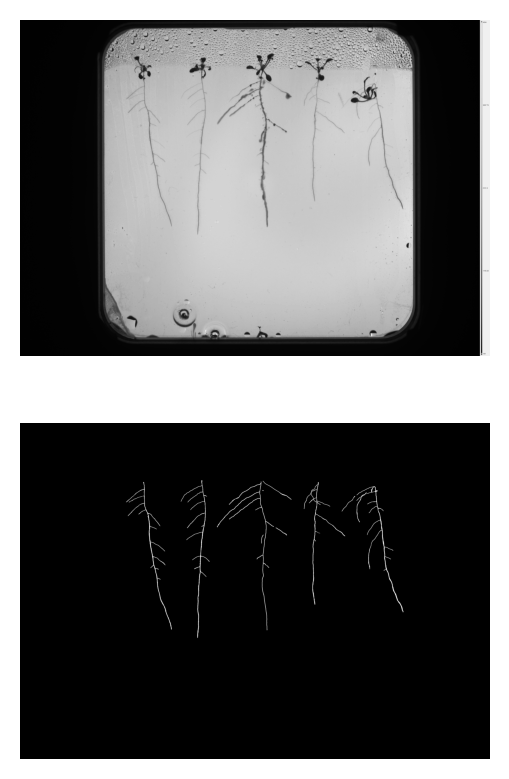

In [7]:
img_patch = ("../Task_2/datasets/Y2B_23/images/train/038_43-14-ROOT1-2023-08-08_pvdCherry_OD001_f6h1_04-Fish Eye Corrected.png")
mask_patch = ("../Task_2/datasets/Y2B_23/masks/038_43-14-ROOT1-2023-08-08_pvdCherry_OD001_f6h1_04-Fish Eye Corrected_root_mask.tif")

image = cv2.imread(img_patch, 0)
mask = cv2.imread(mask_patch, 0)


fig, ax = plt.subplots(2, dpi=200)
ax[0].imshow(image, cmap='gray')
ax[0].axis('off')
ax[1].imshow(mask, cmap='gray')
ax[1].axis('off')

In [ ]:
def padder(image, patch_size):
    """
    Adds padding to an image to make its dimensions divisible by a specified patch size.

    This function calculates the amount of padding needed for both the height and width of an image so that its dimensions become divisible by the given patch size. The padding is applied evenly to both sides of each dimension (top and bottom for height, left and right for width). If the padding amount is odd, one extra pixel is added to the bottom or right side. The padding color is set to black (0, 0, 0).

    Parameters:
    - image (numpy.ndarray): The input image as a NumPy array. Expected shape is (height, width, channels).
    - patch_size (int): The patch size to which the image dimensions should be divisible. It's applied to both height and width.

    Returns:
    - numpy.ndarray: The padded image as a NumPy array with the same number of channels as the input. Its dimensions are adjusted to be divisible by the specified patch size.

    Example:
    - padded_image = padder(cv2.imread('example.jpg'), 128)

    """
    h = image.shape[0]
    w = image.shape[1]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w

    top_padding = int(height_padding/2)
    bottom_padding = height_padding - top_padding

    left_padding = int(width_padding/2)
    right_padding = width_padding - left_padding

    padded_image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return padded_image

In [9]:
def extract_dish(img):
    # height, widh, center of image
    height, widh = img.shape
    center = (widh // 2, height // 2)

    # apply Otsu thresholding
    th, output_im = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    print(f'Otsu algorithm selected the following threshold: {th}')

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(output_im)

    # the biggest blob (object) on each image is Petri dish
    # -infinity - to ensure any score is better
    best_label, best_score = None, -np.inf

    # in loop center is used since Petri dish is near center
    for lab in range(1, num_labels):
        """
        range(1...) - skip label 0 as it is the background
        stats are in format: [x, y, w, h, area] where:
            x.y - top-left corner
            w,h - width and height
            area - area in pixels
        centroids are in format: [cx, cy]
        """
        x, y, w, h, area = stats[lab]
        cx, cy = centroids[lab]

        # big area, near center, square shape
        area_score = area
        center_score = -np.linalg.norm([cx - widh/2, cy - height/2])
        
        #checking aspect ratio
        aspect = w / h
        square_score = -abs(aspect - 1.0)

        # check scores weights (area, square, center)
        score = (1.0 * area_score + 500.0 * square_score + 1000.0 * center_score)

        if score > best_score:
            best_score, best_label = score, lab
    
    x, y, w, h, area = stats[best_label]

    # ensure square that the Pertri dish is fully inside margin is added
    margin = 20
    x_m = max(x - margin, 0)
    y_m = max(y - margin, 0)

    # crop
    side = min(w, h)
    x2 = x + side + margin
    y2 = y + side + margin
    crop = img[y_m:y2, x_m:x2]

    # check crop is square
    assert crop.shape[0] == crop.shape[1], "Crop is not square!"
    return crop

In [10]:
image = extract_dish(image)

Otsu algorithm selected the following threshold: 101.0


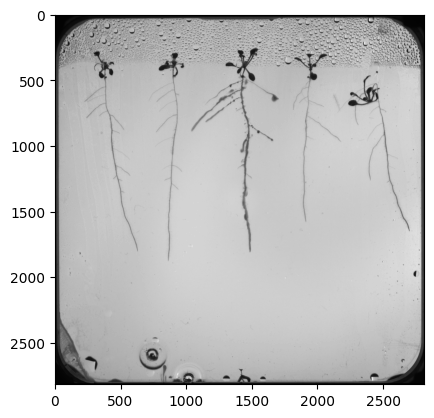

In [12]:
patch_size = 256
padded_image = padder(image, patch_size)
plt.imshow(padded_image, cmap='gray')